# Problem Statement

Politics in America are very divisive. At least that is how it is often portrayed.  Can we use data to try and prove if this division is as great as it seems or more overblown, and can this help the media to try and maintain neutrality.

I have been assigned by Major News Network to try to find the level of division in discourse on the internet.  In particular using reddit posts from the Democrat and Republican subreddits to try and see the strength of the division. This will be through trying to classify the posts using natural language processing. In that way look for the common language used in each subreddit. 

In this way we can try to look at the political difference based on what people are saying not just polls or voting numbers.  We will also see how language can make a difference and what might cause problems when trying to maintain neutral reporting.

# Summary

### Contents:
- [Import and Data](#Import-and-Data)
- [Data Examination/Cleaning](#Data-Examination/Cleaning)
- [Data Visuals](#Data-Visuals)
- [Exporting the Data for Modeling](#Exporting-the-Data-for-Modeling)
- [Vectorizing](#Vectorizing)
- [Outside Research](#Outside-Research)
- [Conclusion](#Conclusion)

Things to look at in this report.
- data obtained through pushshift api(presented in another notebook)
- visuals to try to understand the data based on the difference in word choice or usage
- vectorization of the pulled information
- setting up the data as a csv and exporting
- modeling done as an iterative process using many different models(presented in another notebook)


|Feature|Type|Description|
|---|---|---|
|created_utc|int|The UTC timestamp that the post was created|
|subreddit|object|The subreddit that the post came from|
|title|object|The text of the title of the reddit post|
|char_count|int|Total number of characters in the title of the post|
|word_count|int|Total number of words in the title of the post|



# Import and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
df_d = pd.read_csv('./../data/democrats.csv')

In [3]:
df_d.head()

,created_utc,selftext,subreddit,title
0,1595509312,NaN,democrats,Growing Studies Suggest that COVID-19 Antibodi...
1,1595508499,NaN,democrats,Kim Kardashian addresses Kanye West's mental h...
2,1595507033,NaN,democrats,New Lincoln Project Ad- Failure
3,1595505646,[deleted],democrats,Is Minority Rule Responsible For Current US Un...
4,1595501642,NaN,democrats,"If Trump challenges election results, Democrat..."


In [4]:
df_d.isnull().sum()

created_utc       0
selftext       2247
subreddit         0
title             0
dtype: int64

In [5]:
# code help https://jamesrledoux.com/code/drop_duplicates
df_d = df_d.drop_duplicates(subset='title', keep='first')

In [6]:
df_d.shape

(2906, 4)

In [7]:
df_r = pd.read_csv('./../data/republicans.csv')

In [8]:
df_r.head()

,created_utc,selftext,subreddit,title
0,1595509617,NaN,Republican,U.S. gives China 72 hours to shut Houston cons...
1,1595509411,NaN,Republican,Growing Studies Suggest that COVID-19 Antibodi...
2,1595508368,NaN,Republican,Alan Dershowitz: 'McCloskeys Holding Guns in F...
3,1595508324,[removed],Republican,[Question] Why Do Republicans Dislike Fauci?
4,1595500153,[removed],Republican,Y’all Sending Kids to School?


In [9]:
df_r['created_utc'].value_counts()

1593553343    2
1593534551    2
1593123077    2
1593798561    2
1594502476    2
             ..
1594983061    1
1593177184    1
1593626207    1
1593635473    1
1593973052    1
Name: created_utc, Length: 2995, dtype: int64

In [10]:
df_r = df_r.drop_duplicates(subset='title', keep='first')

In [11]:
df_r.shape

(2900, 4)

In [12]:
df_r.isnull().sum()

created_utc       0
selftext       2336
subreddit         0
title             0
dtype: int64

After looking at the null values I am going to try and procede forward using the titles of the reddit posts as the text of most posts does not really exist so I do not think it will help with this classification.  I also drop the duplicate titles from each dataframe as they will not be helpful in the analysis and are only a small number in the dataset.

# Data Examination/Cleaning

In [100]:
#making a single dataframe
df = pd.concat([df_d,df_r])

In [101]:
df = df.drop(columns = ['created_utc','selftext'])

In [102]:
#lesson 5.05 making sure that the two subreddits are values of 1 and 0
df['subreddit'] = df['subreddit'].map({'Republican': 0, 'democrats': 1})
df = df.rename(columns={'subreddit': 'subreddit_bool'})

In [103]:
df.head()

,subreddit_bool,title
0,1,Growing Studies Suggest that COVID-19 Antibodi...
1,1,Kim Kardashian addresses Kanye West's mental h...
2,1,New Lincoln Project Ad- Failure
3,1,Is Minority Rule Responsible For Current US Un...
4,1,"If Trump challenges election results, Democrat..."


In [104]:
#need to reset the index after combining to make sure that I can combine on the index later
df = df.reset_index(drop=True)

In [105]:
#lab 5.02
# creating a character and a word count column for each type of subreddit
df['char_count'] = df.title.map(len)

In [106]:
df['word_count'] = df.title.map(lambda x: len(x.split()))

In [107]:
df['word_count'].sort_values(ascending=False)[:5]

347     58
2631    56
1672    56
1029    56
63      55
Name: word_count, dtype: int64

In [108]:
#looking at the mean character and word count based on the subreddit
df[df['subreddit_bool']==0]['char_count'].mean()

68.97827586206897

In [109]:
df[df['subreddit_bool']==1]['char_count'].mean()

78.94081211286992

In [110]:
df[df['subreddit_bool']==0]['word_count'].mean()

11.329655172413792

In [111]:
df[df['subreddit_bool']==1]['word_count'].mean()

13.170681348933241

Democratic subreddit has a higher character and word count on average

# Data Visuals

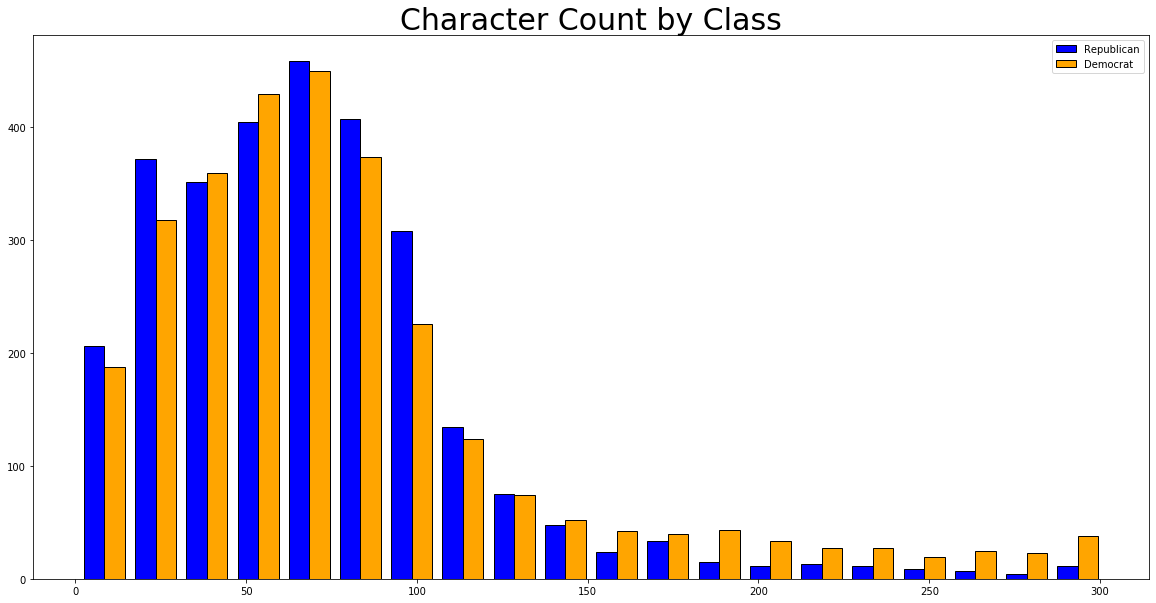

In [25]:
#s5 extra lesson NLP_EDA
#modeling the character and word count comparisons
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit_bool']==0]['char_count'], 
          df[df['subreddit_bool']==1]['char_count']],
         bins=20, color=['blue', 'orange'], ec='k')
plt.title('Character Count by Class', fontsize=30)
plt.legend(['Republican', 'Democrat'])

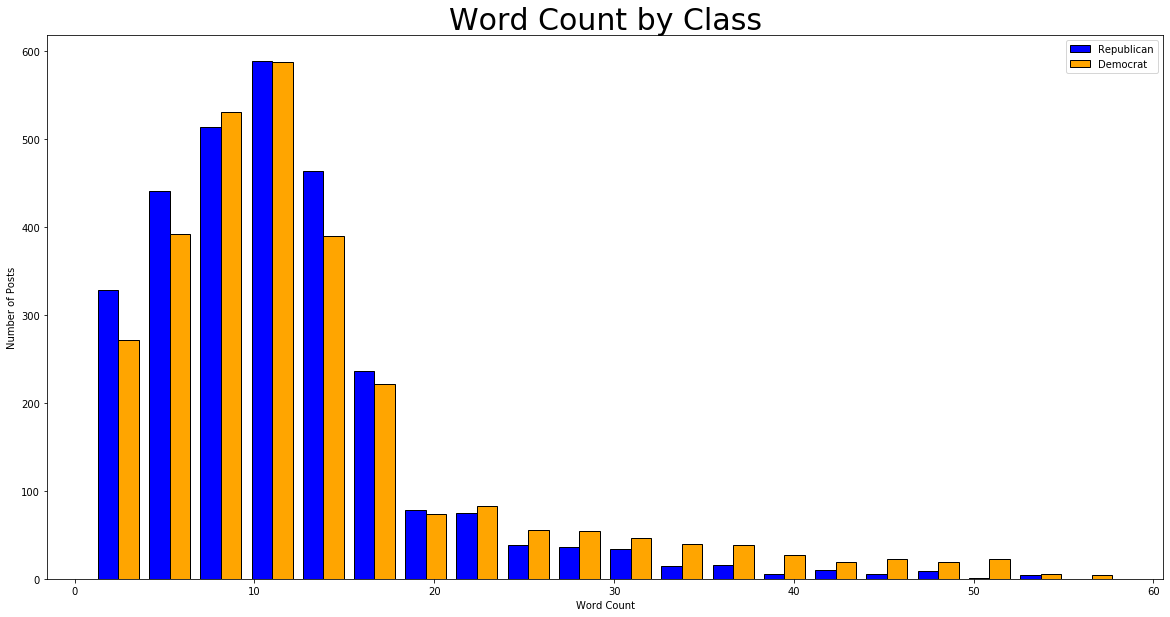

In [26]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit_bool']==0]['word_count'], 
          df[df['subreddit_bool']==1]['word_count']],
         bins=20, color=['blue', 'orange'], ec='k')
plt.title('Word Count by Class', fontsize=30)
plt.legend(['Republican', 'Democrat'])
plt.xlabel('Word Count')
plt.ylabel('Number of Posts')
plt.savefig('./../images/word_count.png');

# Vectorizing

In [27]:
#lab 5.02
# using count vectorization
cvec = CountVectorizer(stop_words='english')

In [28]:
title_cvec = cvec.fit_transform(df['title'])

In [29]:
title_cvec_df = pd.DataFrame(title_cvec.toarray(),
                          columns=cvec.get_feature_names())

In [30]:
title_cvec_df.shape

(5806, 9052)

In [31]:
title_cvec_df.head()

,00,000,005,02,03,03300,07,08,094,096,...,zinn,zombie,zone,zoning,zoom,zoomer,zpfdo,zte,zuby,𝙉𝙚𝙜𝙧𝙤
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# lookin at and modeling common words
most_freq = title_cvec_df.sum(axis=0).sort_values(ascending=False)[:15]

In [33]:
most_freq

trump          1397
biden           524
president       254
black           215
new             212
joe             200
people          199
says            195
democrats       189
just            182
white           182
america         174
republican      164
police          163
republicans     148
dtype: int64

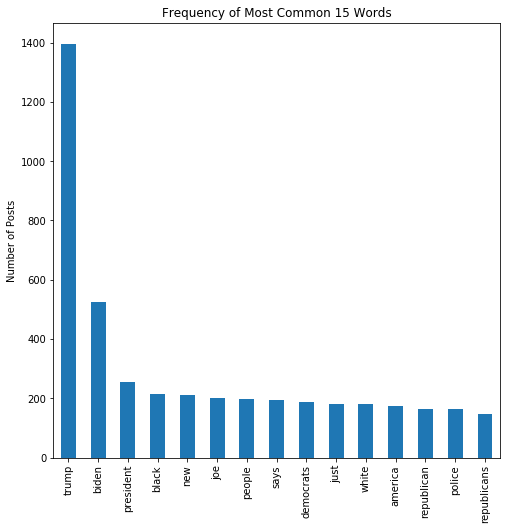

In [34]:
plt.figure(figsize=(10,10))
most_freq.plot(figsize = (8,8),kind='bar', legend = None, title = 'Frequency of Most Common 15 Words');
plt.ylabel('Number of Posts')
plt.savefig('./../images/word_freq.png');

In [35]:
# setting up the dataframe for modeling
final_df = pd.concat([df[['subreddit_bool']],title_cvec_df],axis=1)

In [36]:
final_df

,subreddit_bool,00,000,005,02,03,03300,07,08,094,...,zinn,zombie,zone,zoning,zoom,zoomer,zpfdo,zte,zuby,𝙉𝙚𝙜𝙧𝙤
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#looking at the words my average and sum based on the subreddit categories
final_df.groupby('subreddit_bool').mean().T.sort_values(0, ascending=False).head(20)

subreddit_bool,0,1
trump,0.137241,0.343772
biden,0.054828,0.125602
black,0.048276,0.025809
white,0.039655,0.023056
police,0.037586,0.018582
people,0.033103,0.035444
new,0.032414,0.040606
says,0.030690,0.036476
president,0.028621,0.058844
republicans,0.028621,0.022368


In [38]:
final_df.groupby('subreddit_bool').mean().T.sort_values(1, ascending=False).head(20)

subreddit_bool,0,1
trump,0.137241,0.343772
biden,0.054828,0.125602
president,0.028621,0.058844
joe,0.026897,0.041982
democrats,0.024138,0.040950
new,0.032414,0.040606
says,0.030690,0.036476
coronavirus,0.010000,0.036476
america,0.024483,0.035444
people,0.033103,0.035444


In [39]:
final_df.groupby('subreddit_bool').sum().T.sort_values(0, ascending=False).head(20)

subreddit_bool,0,1
trump,398,999
biden,159,365
black,140,75
white,115,67
police,109,54
people,96,103
new,94,118
says,89,106
president,83,171
republicans,83,65


In [40]:
final_df.groupby('subreddit_bool').sum().T.sort_values(1, ascending=False).head(20)

subreddit_bool,0,1
trump,398,999
biden,159,365
president,83,171
joe,78,122
democrats,70,119
new,94,118
says,89,106
coronavirus,29,106
america,71,103
people,96,103


In [41]:
#s5 extra lesson NLP_EDA
#looking at the top common words it seems with so many in common it could be a problem for modeling
top_words_r = list(final_df.groupby('subreddit_bool').
     mean().T.sort_values(0, ascending=False).head(20).index)

top_words_d = list(final_df.groupby('subreddit_bool').
     mean().T.sort_values(1, ascending=False).head(20).index)
top_words_overlap = [d for d in top_words_d if d in top_words_r]
top_words_overlap

['trump',
 'biden',
 'president',
 'joe',
 'democrats',
 'new',
 'says',
 'america',
 'people',
 'just',
 'republican',
 'black']

# Exporting the Data for Modeling

In [112]:
final_df.to_csv('./../data/final.csv', index=False)

In [113]:
#lesson 5.05
#just as a check I am running a fast TF-IDF to see if it makes a difference
tvec = TfidfVectorizer(stop_words = 'english')

In [114]:

tvec_df = pd.DataFrame(tvec.fit_transform(df['title']).toarray(),
                  columns=tvec.get_feature_names())
tvec_df.head()

,00,000,005,02,03,03300,07,08,094,096,...,zinn,zombie,zone,zoning,zoom,zoomer,zpfdo,zte,zuby,𝙉𝙚𝙜𝙧𝙤
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
final_tvec_df = pd.concat([df[['subreddit_bool']],tvec_df],axis=1)

In [116]:
final_tvec_df.head()

,subreddit_bool,00,000,005,02,03,03300,07,08,094,...,zinn,zombie,zone,zoning,zoom,zoomer,zpfdo,zte,zuby,𝙉𝙚𝙜𝙧𝙤
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
final_tvec_df.to_csv('./../data/final_tvec.csv', index=False)

# Outside Research

https://www.pewresearch.org/topics/political-polarization/
good example of known political differences through polls

https://www.ap.org/explore/divided-america/
exploration of division based on issues

https://www.reddit.com/r/democrats/
democrats subreddit

https://www.reddit.com/r/Republican/
republican subreddit

Examples from the two subreddits of similar stories from different sides:

2 From Democrats

Pelosi To Trump: You’re Getting Kicked Out If You Lose The Race Whether You Like It Or Not
https://talkingpointsmemo.com/news/pelosi-to-trump-youre-getting-kicked-out-if-you-lose-the-race-whether-you-like-it-or-not

Trump Plans to Expand Federal Invasion of American Cities.
https://www.motherjones.com/anti-racism-police-protest/2020/07/trump-border-patrol-cities-portland-chicago/

2 From Republicans

DECLARATION OF WAR: Deranged Pelosi insists President Trump will be removed from office “whether he knows it yet or not”, announces plans for parallel Inaugural Day Address & threatens to “fumigate” him from White House. PREPARE FOR HARD COUP
https://www.youtube.com/watch?v=XlH156c_nXw&feature=youtu.be

Trump vows to send feds into cities facing violence, as DHS reportedly drafts Chicago deployment plan
https://www.foxnews.com/politics/trump-vows-to-send-federal-agents-dhs-chicago

https://slate.com/technology/2013/06/how-people-read-online-why-you-wont-finish-this-article.html
the importance of a title when related to reader engagement

# Conclusion

This has resulted in some interesting data.  On the one hand, looking at the reddit and other outside information it would seem that the country is very divided politically.  The problem is that the models for classification do not seem to be able to find a similar result.  I can only get around 64% accuracy on the test data.

What seems to be happening is that although the meaning of an article might be clear to a person about their political leanings the language used is so similar that the computer models have trouble finding the difference. This seems in part due to the way the media tends to report on political news.  Different news sources say similar things but leave out some key words or phrases that might change the meaning of a statement.

This means that care needs to be taken when relaying the news to avoid partisan language.  It also shows the importance of nuance in the language and how it can be abused for an agenda.  As a media company the title of your piece can be as important as the body since it is the first thing people see and can direct the conversation.

With improvement the model can help to show bias in titles and try to help the company maintain a more neutral stance. Thsi can be done by avoiding sarcastic or misleading titles, or statement that use overly hyperbolic language.

### What Next
- expand to other subreddits like ones that might be less partisan
- enhance the vectorization by checking for more hyperparameters
- look into other models that might be better at picking up language nuance
- expand to the comments of the subreddits

Looking at some examples of Predictions to try and understand why

In [132]:
comparison = pd.read_csv('./../data/comparison.csv', index_col = 'Unnamed: 0' )

In [134]:
comparison = pd.concat([df,comparison], axis=1, join='inner')

In [136]:
comparison.head(40)

,subreddit_bool,title,char_count,word_count,subreddit_bool,preds
0,1,Growing Studies Suggest that COVID-19 Antibodi...,69,9,1,0
6,1,You Wish Her Well?,18,4,1,0
18,1,Next Step Actions,17,3,1,0
21,1,Epstein's Biz Associate Says Trump And Ghislai...,75,12,1,1
22,1,RISE,4,1,1,0
24,1,Enough is enough,16,3,1,0
39,1,FUCK BLACK LIVES MATTER.,24,4,1,0
40,1,"Biden wins, even if Trump narrows margins 4% i...",76,15,1,1
48,1,A 16-year-old Hispanic boy climbed over Trump'...,226,40,1,1
52,1,"Down In The Polls, Trump Pitches Fear: 'They W...",105,20,1,1


In [137]:
comparison.tail(40)

,subreddit_bool,title,char_count,word_count,subreddit_bool,preds
5669,0,Tucker Carlson: The angry children toppling st...,106,16,0,0
5671,0,TIME: How the Karen Meme Confronts History of ...,161,26,0,0
5672,0,Why are you so rude?,20,5,0,0
5673,0,Three House Democrats say federal authorities ...,97,14,0,0
5677,0,"America, The Not Racist",23,4,0,0
5679,0,NOT PLAYING AROUND: AG Barr Reveals 500 Invest...,93,15,0,0
5682,0,This Man for Mayor: Fed up Seattle Citizen Beg...,106,17,0,0
5683,0,Trump signs executive order to improve foster ...,57,9,0,1
5685,0,I get my political views from Stardew Valley,44,8,0,0
5686,0,McConnell Gets It Done - Senate Passes Histori...,73,12,0,1


Past the retoric it seems to divide alot of choices based on the words that are more important to certain sides.

Trump mentions seem to go to dems which has a big affect on the data.

Election related going to dems.

Things about police or racism going to republicans.

Should look at the affect Trump is having on the model seems to big

Neutral language seemed harder to predict